# Import libraries

In [1]:
#viewed this
#https://www.kaggle.com/kaanboke/catboost-lightgbm-xgboost-explained-by-shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve


import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier




#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import shap 

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import sys
#!{sys.executable} -m pip install missingno

# Import Data

In [3]:

pd.set_option('max_columns',100)
pd.set_option('max_rows',900)

pd.set_option('max_colwidth',200)

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

# checking for missing or duplicated values

In [4]:
df.duplicated().sum()

0

In [5]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

Missing_Number  Missing_Percent
customerID                     0              0.0
DeviceProtection               0              0.0
TotalCharges                   0              0.0
MonthlyCharges                 0              0.0
PaymentMethod                  0              0.0
PaperlessBilling               0              0.0
Contract                       0              0.0
StreamingMovies                0              0.0
StreamingTV                    0              0.0
TechSupport                    0              0.0
OnlineBackup                   0              0.0
gender                         0              0.0
OnlineSecurity                 0              0.0
InternetService                0              0.0
MultipleLines                  0              0.0
PhoneService                   0              0.0
tenure                         0              0.0
Dependents                     0              0.0
Partner                        0              0.0
SeniorCitizen                  0              0.0
Churn                          0              0.0

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# data cleanning and exploration

- removing non useful data

In [7]:
df1 = df.drop('customerID',axis=1).copy()

In [8]:
#when trying to sum we get erros because of ' ' as total charges. Missing values we want to replace with Nan to more easily deal
#with them
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)


- very little data we can estimate the missing data

In [9]:
missing(df1)

Missing_Number  Missing_Percent
TotalCharges                  11         0.001562
gender                         0         0.000000
SeniorCitizen                  0         0.000000
MonthlyCharges                 0         0.000000
PaymentMethod                  0         0.000000
PaperlessBilling               0         0.000000
Contract                       0         0.000000
StreamingMovies                0         0.000000
StreamingTV                    0         0.000000
TechSupport                    0         0.000000
DeviceProtection               0         0.000000
OnlineBackup                   0         0.000000
OnlineSecurity                 0         0.000000
InternetService                0         0.000000
MultipleLines                  0         0.000000
PhoneService                   0         0.000000
tenure                         0         0.000000
Dependents                     0         0.000000
Partner                        0         0.000000
Churn                          0         0.000000

- We have imbalanced data.


In [10]:
y = df1['Churn']
print(f'Percentage of Churn:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} customer)\nPercentage of customer did not churn: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} customer)')


Percentage of Churn:  26.54 %  --> (1869 customer)
Percentage of customer did not churn: 73.46  %  --> (5174 customer)


- list of numerical / categorical features

In [11]:
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

numerical= df1.select_dtypes('number').columns

categorical = df1.select_dtypes('object').columns

print(f'Numerical Columns:  {df1[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df1[categorical].columns}')

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')


Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


- exploring numeric data

In [12]:
df1['tenure']= df1['tenure'].astype(float)
numerical= df1.select_dtypes('number').columns

df1[numerical].describe()

SeniorCitizen       tenure  MonthlyCharges  TotalCharges        Churn
count    7043.000000  7043.000000     7043.000000   7032.000000  7043.000000
mean        0.162147    32.371149       64.761692   2283.300441     0.265370
std         0.368612    24.559481       30.090047   2266.771362     0.441561
min         0.000000     0.000000       18.250000     18.800000     0.000000
25%         0.000000     9.000000       35.500000    401.450000     0.000000
50%         0.000000    29.000000       70.350000   1397.475000     0.000000
75%         0.000000    55.000000       89.850000   3794.737500     1.000000
max         1.000000    72.000000      118.750000   8684.800000     1.000000

In [13]:
df1[['tenure', 'MonthlyCharges', 'TotalCharges']].iplot(kind='histogram',subplots=True,bins=50)

- weak correlation between our Y and numerical features
- strong correlation between total charges and Y

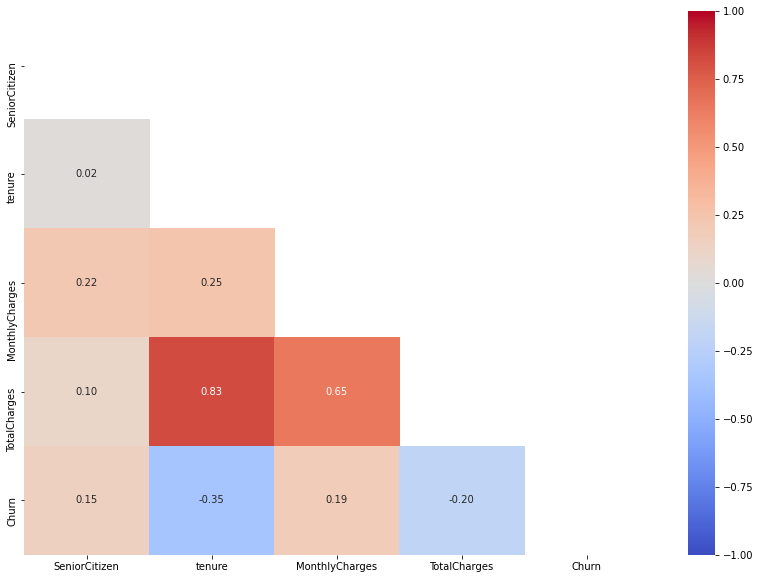

In [14]:
matrix = np.triu(df1[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df1[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

- cardinality of our categoricals is not higher

In [15]:
df1[categorical].nunique()

gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

# gender and churn

- gender doesn't seem to matter

In [16]:
print (f'A female customer has a probability of {round(df1[df1["gender"]=="Female"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A male customer has a probability of {round(df1[df1["gender"]=="Male"]["Churn"].mean()*100,2)} % churn')

print()

A female customer has a probability of 26.92 % churn

A male customer has a probability of 26.16 % churn



In [17]:
fig = px.histogram(df1, x="gender", color="Churn",width=400, height=400)
fig.show()

- Customer without any relationship, single customer almost 1.7 times more likely churn than cutomer with a partner.

# SO and Churn

In [18]:
print (f'A customer with a partner has a probability of {round(df1[df1["Partner"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any partner has a probability of {round(df1[df1["Partner"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a partner has a probability of 19.66 % churn

A customer without any partner has a probability of 32.96 % churn



In [19]:
fig = px.histogram(df1, x="Partner", color="Churn",width=400, height=400)
fig.show()

# dependents and churn

- no dependents are more likely to churn

In [20]:
print (f'A customer with dependents has a probability of {round(df1[df1["Dependents"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any dependents has a probability of {round(df1[df1["Dependents"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with dependents has a probability of 15.45 % churn

A customer without any dependents has a probability of 31.28 % churn



In [21]:
fig = px.histogram(df1, x="Dependents", color="Churn",width=400, height=400)
fig.show()

# CELL PHONE PLAN AND CHURN

- very small difference. if they have cell phone plan or not

In [22]:
print (f'A customer with a phone service has a probability of {round(df1[df1["PhoneService"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any phone service has a probability of {round(df1[df1["PhoneService"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a phone service has a probability of 26.71 % churn

A customer without any phone service has a probability of 24.93 % churn



In [23]:
fig = px.histogram(df1, x="PhoneService", color="Churn",width=400, height=400)
fig.show()

# number of lines and churn

- multiple lines does not seem to affect churn rate

In [24]:
df1['MultipleLines']= df1['MultipleLines'].replace('No phone service','No')

In [25]:
print (f'A customer with a multiple lines has a probability of {round(df1[df1["MultipleLines"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without multiple lines has a probability of {round(df1[df1["MultipleLines"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a multiple lines has a probability of 28.61 % churn

A customer without multiple lines has a probability of 25.02 % churn



In [26]:
fig = px.histogram(df1, x="MultipleLines", color="Churn",width=400, height=400)
fig.show()

# internet type and churn

- type of internet seems to have a major effect on churn rate (Fiber optic is the latest and greatest so more tech savy?)

In [27]:
print (f'A customer with a Fiber Optic internet service has a probability of {round(df1[df1["InternetService"]=="Fiber optic"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a DSL internet service has a probability of {round(df1[df1["InternetService"]=="DSL"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any internet service has a probability of {round(df1[df1["InternetService"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Fiber Optic internet service has a probability of 41.89 % churn

A customer with a DSL internet service has a probability of 18.96 % churn

A customer without any internet service has a probability of 7.4 % churn



In [28]:
fig = px.histogram(df1, x="InternetService", color="Churn",width=400, height=400)
fig.show()

# online security and churn

- customers without online security are more likely to churn

In [29]:
df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

In [30]:
print (f'A customer with a online security has a probability of {round(df1[df1["OnlineSecurity"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any online security has a probability of {round(df1[df1["OnlineSecurity"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a online security has a probability of 14.61 % churn

A customer without any online security has a probability of 31.33 % churn



In [31]:
fig = px.histogram(df1, x="OnlineSecurity", color="Churn",width=400, height=400)
fig.show()

# online backup and churn

- customers with an online backup are much more likely to churn

In [32]:
print (f'A customer with a online backup has a probability of {round(df1[df1["OnlineBackup"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any online backup has a probability of {round(df1[df1["OnlineBackup"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a online backup has a probability of 21.53 % churn

A customer without any online backup has a probability of 29.17 % churn



In [33]:
fig = px.histogram(df1, x="OnlineBackup", color="Churn",width=400, height=400)
fig.show()

# device protection and churn 

In [34]:
print (f'A customer with a device protection has a probability of {round(df1[df1["DeviceProtection"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any device protection has a probability of {round(df1[df1["DeviceProtection"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a device protection has a probability of 22.5 % churn

A customer without any device protection has a probability of 28.65 % churn



In [35]:
fig = px.histogram(df1, x="DeviceProtection", color="Churn",width=400, height=400)
fig.show()

# tech support and churn

- customer with out tech support more likely to churn

In [36]:
print (f'A customer with a Tech Support has a probability of {round(df1[df1["TechSupport"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any Tech Support has a probability of {round(df1[df1["TechSupport"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Tech Support has a probability of 15.17 % churn

A customer without any Tech Support has a probability of 31.19 % churn



In [37]:
fig = px.histogram(df1, x="TechSupport", color="Churn",width=400, height=400)
fig.show()

# streaming services and churn

In [38]:
print (f'A customer with a Streaming TV service with the company has a probability of {round(df1[df1["StreamingTV"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any Streaming TV service with the company has a probability of {round(df1[df1["StreamingTV"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a Streaming TV service with the company has a probability of 30.07 % churn

A customer without any Streaming TV service with the company has a probability of 24.33 % churn



In [39]:
fig = px.histogram(df1, x="StreamingTV", color="Churn",width=400, height=400)
fig.show()

- customer with streaming service more likely to churn

# Streaming Movies Service and Churn

In [40]:

print (f'A customer with a Streaming movies service with the company has a probability of {round(df1[df1["StreamingMovies"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without any Streaming movies service with the company has a probability of {round(df1[df1["StreamingMovies"]=="No"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a Streaming movies service with the company has a probability of 29.94 % churn

A customer without any Streaming movies service with the company has a probability of 24.38 % churn



In [41]:
fig = px.histogram(df1, x="StreamingMovies", color="Churn",width=400, height=400)
fig.show()

- customer with streaming movies service mroe likely to churn

# contract type and churn

In [42]:
print (f'A customer with a Month to month contract has a probability of {round(df1[df1["Contract"]=="Month-to-month"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Two year contract has a probability of {round(df1[df1["Contract"]=="Two year"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a One year contract has a probability of {round(df1[df1["Contract"]=="One year"]["Churn"].mean()*100,2)} % churn')

print()

A customer with a Month to month contract has a probability of 42.71 % churn

A customer with a Two year contract has a probability of 2.83 % churn

A customer with a One year contract has a probability of 11.27 % churn



In [43]:
fig = px.histogram(df1, x="Contract", color="Churn",width=400, height=400)
fig.show()

- contract type highly likely to affect churn

# paperless billing and churn

In [44]:

print (f'A customer with a Paperless billing  has a probability of {round(df1[df1["PaperlessBilling"]=="Yes"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer without a Paperless billing has a probability of {round(df1[df1["PaperlessBilling"]=="No"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Paperless billing  has a probability of 33.57 % churn

A customer without a Paperless billing has a probability of 16.33 % churn



In [45]:
fig = px.histogram(df1, x='PaperlessBilling', color="Churn",width=400, height=400)
fig.show()

- paperless billing customers more likely to churn

# payment method and churn

In [46]:

print (f'A customer with a Payment method as a Electornic Check has a probability of {round(df1[df1["PaymentMethod"]=="Electronic check"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Payment method as a Mailed Check has a probability of {round(df1[df1["PaymentMethod"]=="Mailed check"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Payment method as a Bank transfer (automatic) has a probability of {round(df1[df1["PaymentMethod"]=="Bank transfer (automatic)"]["Churn"].mean()*100,2)} % churn')

print()

print (f'A customer with a Payment method as a Credit card (automatic) has a probability of {round(df1[df1["PaymentMethod"]=="Credit card (automatic)"]["Churn"].mean()*100,2)} % churn')

print()


A customer with a Payment method as a Electornic Check has a probability of 45.29 % churn

A customer with a Payment method as a Mailed Check has a probability of 19.11 % churn

A customer with a Payment method as a Bank transfer (automatic) has a probability of 16.71 % churn

A customer with a Payment method as a Credit card (automatic) has a probability of 15.24 % churn



In [47]:
fig = px.histogram(df1, x='PaymentMethod', color="Churn",width=400, height=400)
fig.show()

- electronic check highly likely to churn

- **`Gender`** : There is not much difference between gender on the churn rate. We won't include gender into our model.
- **`Partner`** :  Customer without any relationship, single customer almost 1.7 times more likely churn than cutomer with a partner.
- **`Dependents`** : Customer without any dependents, almost 2.03 times more likely churn than cutomer with a dependent.
- **`Phone Service`**: Churn rate difference between customer has a phone service with the company and customer does not have a home phone service with the company is very small. We won't include phone service into our model.
- **`Multiple Lines`** : Churn rate difference between customer has a multiple lines phone service with the company and customer does not have a multiple line phone service with the company is very small.
- **`ìnternet Service`** : Customer with fiber optic internet with the company compare to customer without any internet service with the company 5.66 times more likely to churn.
- **`Online Security`**: A customer with an online security service with the company almost 2.14 times less likely to leave the company than a customer without any online security service with the company.
- **`Online Backup`** A customer with an online backup service with the company almost 1.35 times less likely to leave the company than a customer without any online backup service with the company.
- **`Device Protection`** : A customer with a device protection service with the company almost 1.27 times less likely to leave the company than a customer without any a device protection service with the company.
- **`Tech Support`** : A customer with a Tech Support service with the company almost 2.06 times less likely to leave the company than a customer without any a Tech Support service with the company.
- **`Streaming TV Service`** : A customer with a Streaming TV service with the company almost 1.24 times more likely to leave the company than a customer without any a Streaming TV service with the company.
- **`Streaming Movies Service`** : A customer with a Streaming Movies service with the company almost 1.23 times more likely to leave the company than a customer without any a Streaming movies service with the company.
- **`Contract Type`** : Great differences based on the contract were seen in the histogram and mean differences.
    - Customer with the 2 year contract almost 15.1 times less likely to churn compare to customer with a monthly contract.
    - On the other hand customer with the 1 year contract almost 3.79 times less likely to churn compare to customer with a monthly contract.
- **`Paperless Billing`** : A customer with a paperless billing with the company almost 2.06 times more likely to leave the company than a customer without a paperless billing with the company.
- **`Payment Method`** : Almost half of the customers with a payment method as a Electornic Check churn, which is a quite big percentage.


# using catboost, XGboost, LightGBM because these 3 algorithms tune based sampling size. They're good for imbalanced data

- catboost

In [48]:
accuracy= []
recall =[]
roc_auc= []
precision = []

model_names =[]

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])


df1['tenure']= df1['tenure'].astype(float)
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')


X= df1.drop('Churn', axis=1)
y= df1['Churn']

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_base = CatBoostClassifier(verbose=False,random_state=0)

catboost_base.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df1

Accuracy  Recall  Roc_Auc  Precision
Catboost_default    0.8074  0.5192    0.717     0.6946

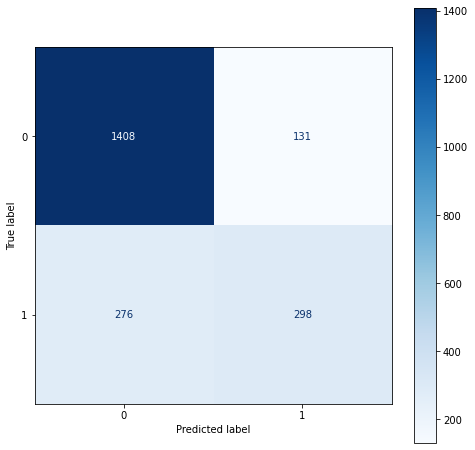

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- predicted slightly > 50% of churned customers. This is pretty good!

# CatBoost (with adjusted Scale_Pos_Weight = 3) Deals With Imbalanced Data

In [50]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['tenure']= df1['tenure'].astype(float)
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')


X= df1.drop('Churn', axis=1)
y= df1['Churn']

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=3)

catboost.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_3']
result_df2 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df2

Accuracy  Recall  Roc_Auc  Precision
Catboost_adjusted_weight_3    0.7534  0.8415    0.781      0.529

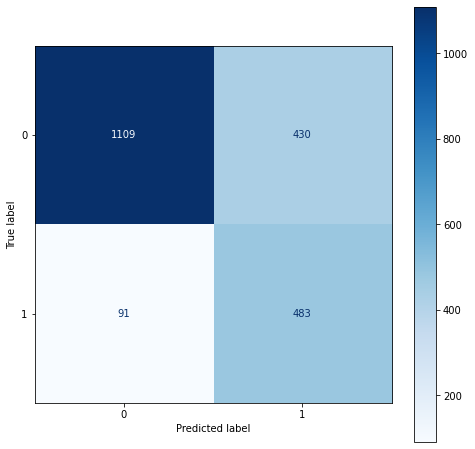

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

- big gains! 32% lift in recall!

In [62]:
accuracy= []
recall =[]
roc_auc= []
precision = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_5 = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=5)

catboost_5.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = catboost_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_5']
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

Accuracy  Recall  Roc_Auc  Precision
Catboost_adjusted_weight_5    0.6796  0.9181   0.7544     0.4555

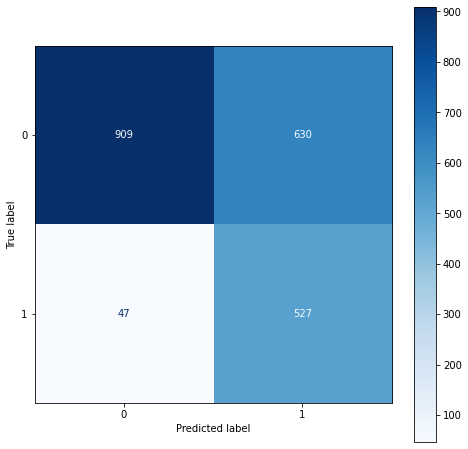

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [65]:
explainercat = shap.TreeExplainer(catboost_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

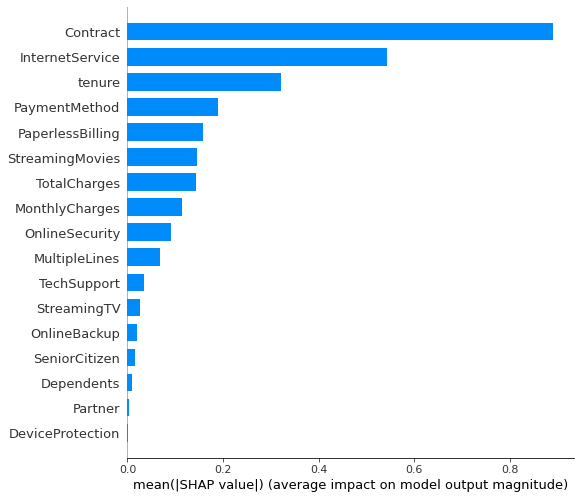

In [74]:
shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

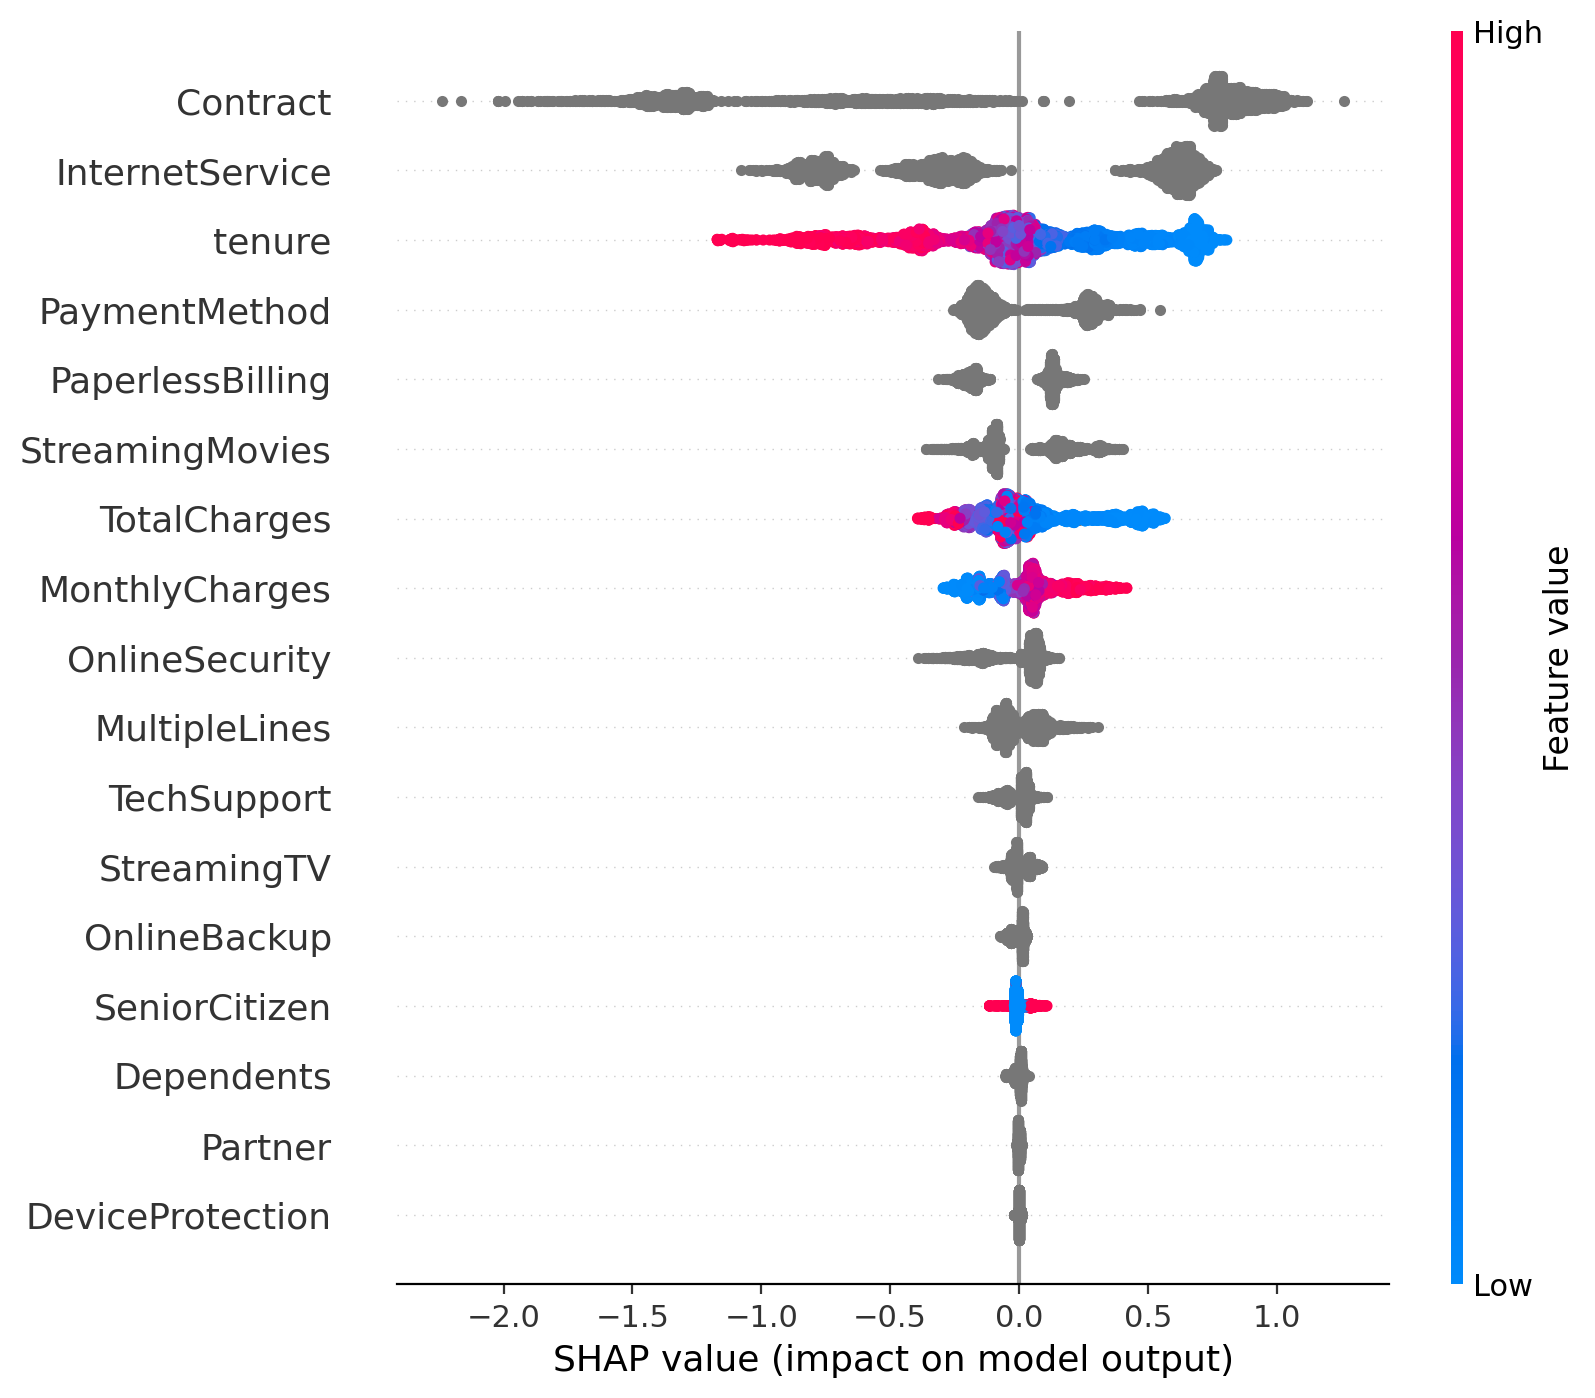

In [69]:
fig = plt.subplots(figsize=(6,6),dpi=200)

ax = shap.summary_plot(shap_values_cat_train, X_train,plot_type="dot")

-color coding only works for numerical data! gray means it was cat.

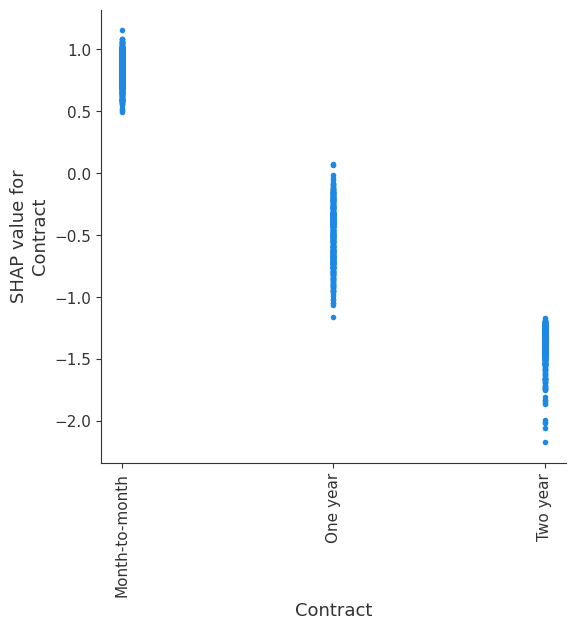

In [70]:
fig, ax= plt.subplots(figsize=(6,6),dpi=100)
shp_plt = shap.dependence_plot("Contract", shap_values_cat_test, X_test,ax=ax,interaction_index=None)

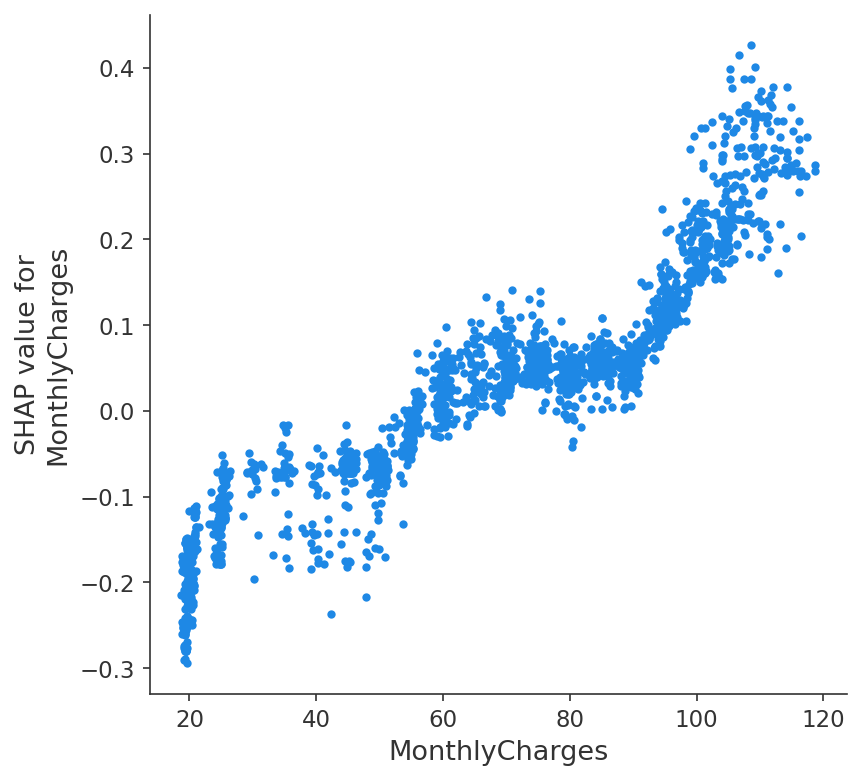

In [71]:
fig, ax1= plt.subplots(figsize=(6,6),dpi=150)

shp_plt = shap.dependence_plot("MonthlyCharges", shap_values_cat_test,X_test,ax=ax1, interaction_index=None)

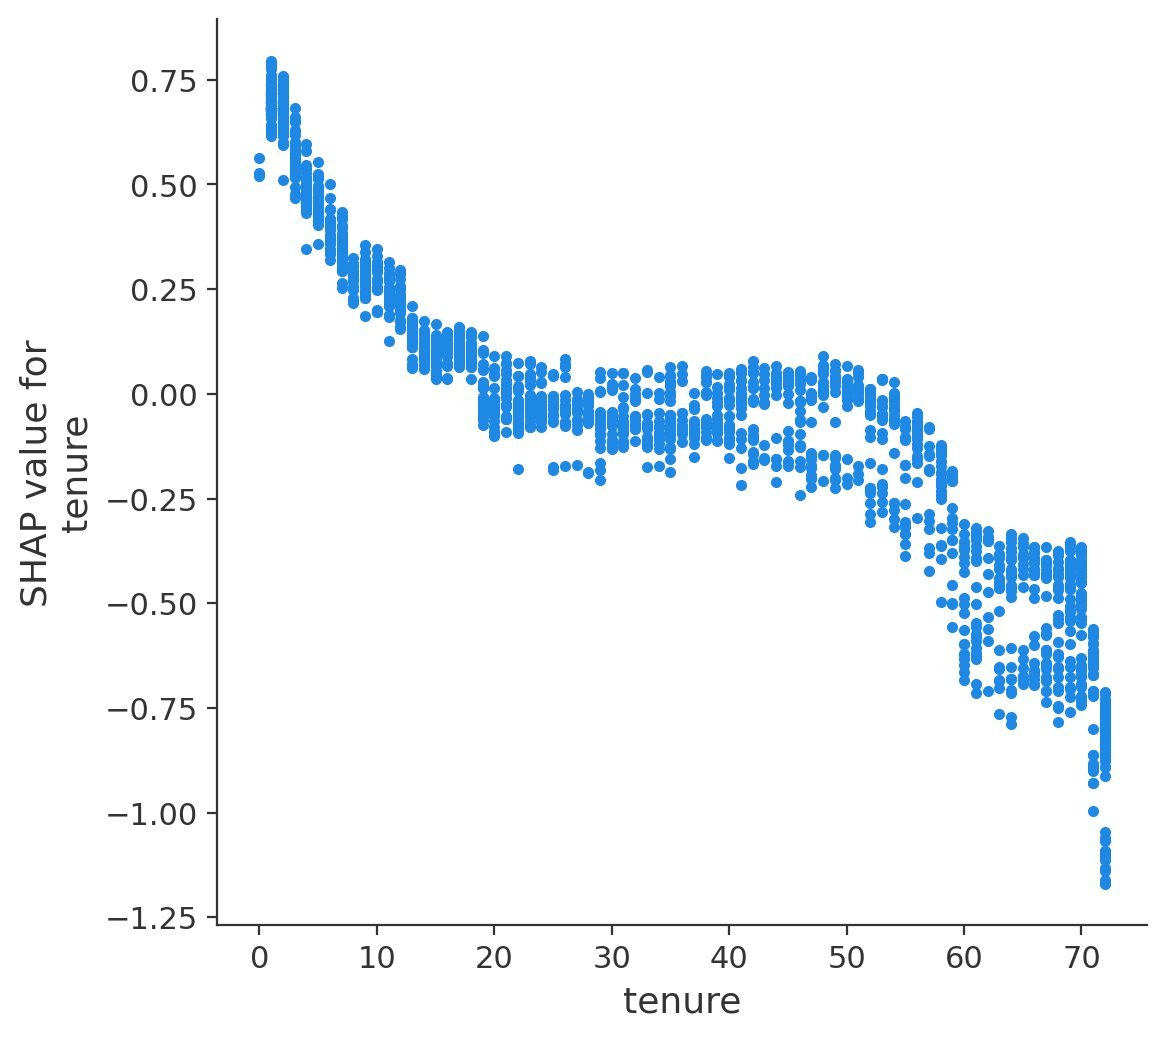

In [72]:
fig, ax2 = plt.subplots(figsize=(6,6),dpi=200)
shap.dependence_plot("tenure", shap_values_cat_test, X_test,interaction_index=None,ax=ax2)

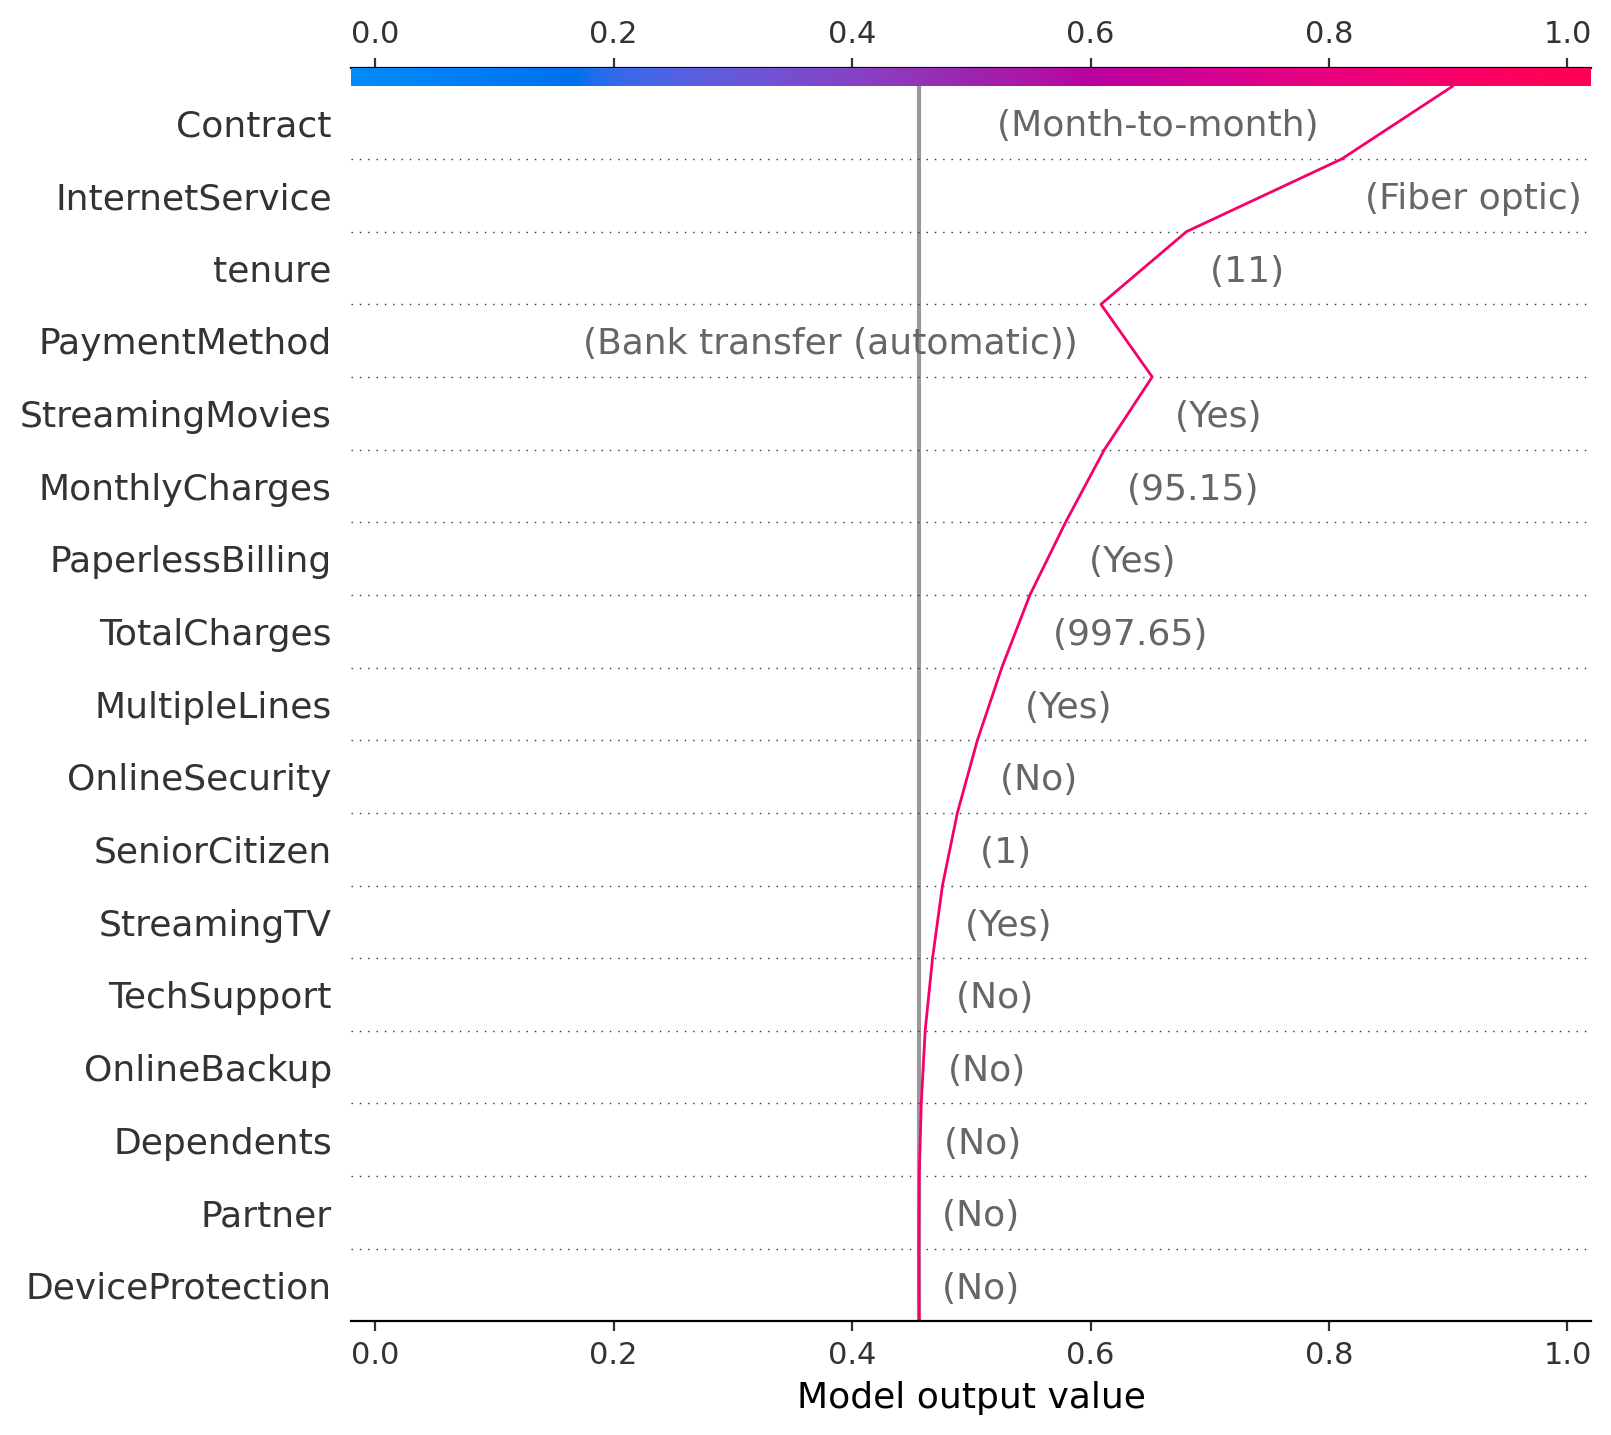

In [76]:
fig = plt.subplots(figsize=(6,6),dpi=200)
ax_2= shap.decision_plot(explainercat.expected_value, shap_values_cat_test[15], X_test.iloc[[15]], link= "logit")